In [ ]:
# !pip -qq install langchain
# !pip -qq install langchain-core
# !pip -qq install langchain-community
# !pip install chromadb
!pip install evaluate
!pip install rouge_score



  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=95c27141c1fd602765216e098dab78518de33eafd842bfa7e7059bd7175cf8b2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import json
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import  nltk
import re
import torch
from torch.utils.data import Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.model_selection import train_test_split
from evaluate import load
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer



In [ ]:
nltk.download("stopwords")
stop_words = set(nltk.corpus.stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def load_json(file_path):


    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

data = load_json('training.json')
df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"], format="%d/%m/%y %H:%M")


## EDA

In [ ]:
print("size of the dataset:", df.shape)

size of the dataset: (258, 5)


In [ ]:
print("Missing values in each column:")
print(df.isna().sum())
print("Duplication count in 'question' and 'answer' columns:")
duplicates_2 = df.duplicated(subset=["question", "answer"]).sum()
print(f"Number of duplicate entries: {duplicates_2}")

print("Duplication count in 'question' and 'answer' and 'user_id' columns:")
duplicates_3 = df.duplicated(subset=["question", "answer","user_id"]).sum()
print(f"Number of duplicate entries with : {duplicates_3}")

print(f"Number of unique answers: {df['answer'].nunique()}")


Missing values in each column:
question    0
control     0
user_id     0
answer      0
date        0
dtype: int64
Duplication count in 'question' and 'answer' columns:
Number of duplicate entries: 2
Duplication count in 'question' and 'answer' and 'user_id' columns:
Number of duplicate entries with : 0
Number of unique answers: 30


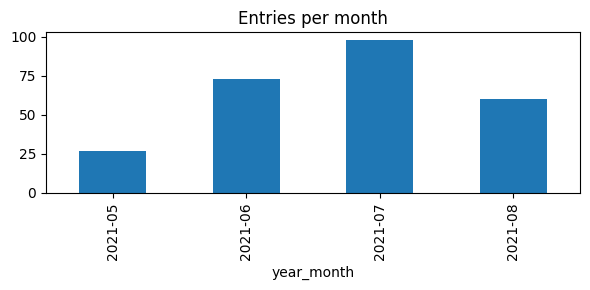

In [ ]:

df["year_month"] = df["date"].dt.to_period("M")
df.groupby("year_month").size().plot(kind="bar", figsize=(6, 3), title="Entries per month")

plt.tight_layout();
plt.show()

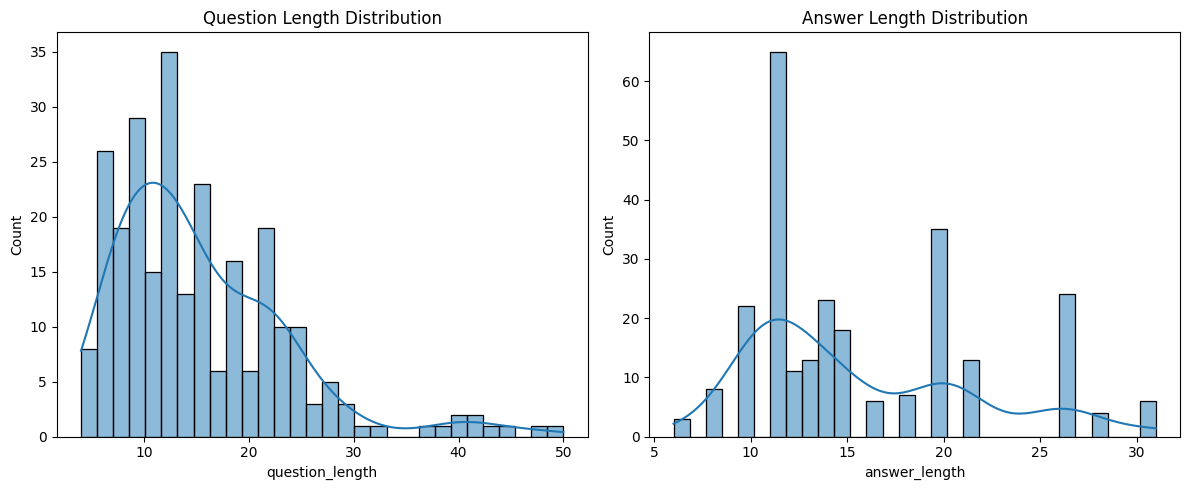

In [ ]:
df["question_length"] = df["question"].apply(lambda x: len(x.split()))
df["answer_length"] = df["answer"].apply(lambda x: len(x.split()))
fig,ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Question Length Distribution")
sns.histplot(df["question_length"], bins=30, kde=True, ax=ax[0])
ax[1].set_title("Answer Length Distribution")
sns.histplot(df["answer_length"], bins=30, kde=True, ax=ax[1])
plt.tight_layout()
plt.show()

In [ ]:
def preprocess(text):
    text = re.sub(r"[^A-Za-z0-9 ]", " ", text.lower())
    return [w for w in text.split() if w not in stop_words and len(w) > 2]

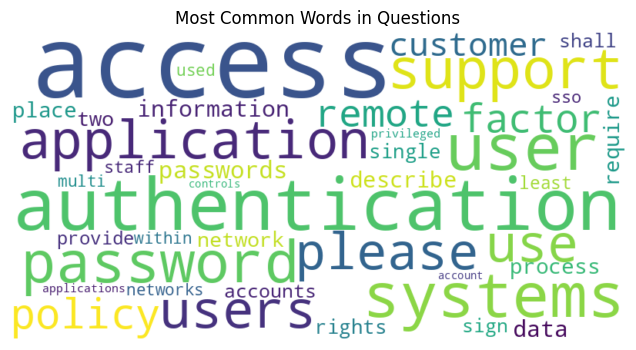

In [ ]:
question_tokens = sum(df["question"].apply(preprocess).tolist(), [])
token_counts = Counter(question_tokens).most_common(40)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(token_counts))
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Questions")
plt.show()


# Models

In [ ]:
SEED = 42
def set_all_seeds(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
set_all_seeds(SEED)


In [ ]:
train_df["question"] = train_df["question"].astype(str)
train_df["answer"] = train_df["answer"].astype(str)

train_df, temp_df = train_test_split(df, test_size=0.30, random_state=SEED, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED, shuffle=True)
print(f"Current split sizes \n train: {train_df.shape} \n val: {val_df.shape} \n test: {test_df.shape}")


Current split sizes 
 train: (180, 8) 
 val: (39, 8) 
 test: (39, 8)


In [ ]:


class QuestionAnswerDataset(Dataset):
    def __init__(self, df, tokenizer, max_input_len=128, max_target_len=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        q = "answer the security question: " + self.df.loc[idx, "question"]
        a = self.df.loc[idx, "answer"]

        inputs = self.tokenizer(q,
                                max_length=self.max_input_len,
                                truncation=True,
                                padding="max_length",
                                return_tensors="pt")
        targets = self.tokenizer(a,
                                 max_length=self.max_target_len,
                                 truncation=True,
                                 padding="max_length",
                                 return_tensors="pt")

        return {
            "input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "labels": targets.input_ids.squeeze(),
        }






## T5

In [ ]:
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

train_dataset = QuestionAnswerDataset(train_df, tokenizer)
val_dataset   = QuestionAnswerDataset(val_df, tokenizer)
test_dataset  = QuestionAnswerDataset(test_df, tokenizer)

training_args = TrainingArguments(
    output_dir="./t5_skypher",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_total_limit=2,
    logging_steps=20,
    logging_dir="./logs",
    learning_rate=5e-4,
    report_to="none",
    eval_strategy="epoch"
)

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_dataset,
    eval_dataset    = val_dataset,
    tokenizer       = tokenizer,
)

trainer.train()
trainer.save_model("t5_skypher_trained")

/tmp/ipython-input-50-1666574506.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.494700,0.178570
2,0.105300,0.069318
3,0.047000,0.035335
4,0.017000,0.023202
5,0.016200,0.022681


In [ ]:
def generate_answers(questions, model, tokenizer,
                     batch_size=16, max_len=128):
    model.eval()
    answers = []
    for i in tqdm(range(0, len(questions), batch_size), desc="Generating"):
        prompts = ["answer the security question: " + q
                   for q in questions[i:i+batch_size]]

        enc = tokenizer(prompts, return_tensors="pt",
                        padding=True, truncation=True,
                        max_length=256).to(device)

        with torch.no_grad():
            outs = model.generate(**enc,
                                  max_length=max_len,
                                  do_sample=False)

        answers.extend(tokenizer.batch_decode(outs,
                                              skip_special_tokens=True))
    return answers

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("t5_skypher_trained").to(device)
tokenizer = T5Tokenizer.from_pretrained("t5_skypher_trained")

test_df["generated_answer"] = generate_answers(
    test_df["question"].tolist(),
    model, tokenizer, batch_size=16, max_len=128
)



Generating: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


In [ ]:
def evaluate_score(references, hypotheses):



    assert len(references) == len(hypotheses)

    smooth = SmoothingFunction().method4
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    bleu1_vals, bleu2_vals, bleu3_vals, bleu4_vals, rouge_vals = [], [], [], [], []

    for ref, hyp in zip(references, hypotheses):
        ref_tokens = ref.split()
        hyp_tokens = hyp.split()

        bleu1_vals.append(
            sentence_bleu([ref_tokens], hyp_tokens,
                          weights=(1, 0, 0, 0), smoothing_function=smooth)
        )
        bleu2_vals.append(
            sentence_bleu([ref_tokens], hyp_tokens,
                          weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
        )
        bleu3_vals.append(
            sentence_bleu([ref_tokens], hyp_tokens,
                          weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
        )
        bleu4_vals.append(
            sentence_bleu([ref_tokens], hyp_tokens,
                          weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
        )

        rouge_vals.append(scorer.score(ref, hyp)['rougeL'].fmeasure)

    return {
        "bleu1":  float(np.mean(bleu1_vals)),
        "bleu2":  float(np.mean(bleu2_vals)),
        "bleu3":  float(np.mean(bleu3_vals)),
        "bleu4":  float(np.mean(bleu4_vals)),
        "rougeL": float(np.mean(rouge_vals)),
    }

metrics = evaluate_score(
    test_df["answer"].astype(str).tolist(),
    test_df["generated_answer"].astype(str).tolist()
)

print("Metrics in our splited test dataset")
print(f"BLEU-1 : {metrics['bleu1']:.4f}")
print(f"BLEU-2 : {metrics['bleu2']:.4f}")
print(f"BLEU-3 : {metrics['bleu3']:.4f}")
print(f"BLEU-4 : {metrics['bleu4']:.4f}")
print(f"ROUGE-L: {metrics['rougeL']:.4f}")



Metrics in our splited test dataset
BLEU-1 : 0.6610
BLEU-2 : 0.6451
BLEU-3 : 0.6399
BLEU-4 : 0.6360
ROUGE-L: 0.6864


In [ ]:
#retrain on full dataset and generate sub file
model_name = "google/flan-t5-base"
tokenizer  = T5Tokenizer.from_pretrained(model_name)
model      = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

full_dataset = QuestionAnswerDataset(df, tokenizer)
args_full = TrainingArguments(
    output_dir          = "./t5_final_full",
    num_train_epochs    = 5,
    per_device_train_batch_size = 4,
    eval_strategy = "no",
    save_total_limit    = 1,
    learning_rate       = 5e-4,
    logging_steps       = 20,
    seed                = SEED,
    report_to           = "none",
)

trainer_full = Trainer(
    model=model,
    args=args_full,
    train_dataset=full_dataset,
    tokenizer=tokenizer,
)

trainer_full.train()
trainer_full.save_model("t5_final_full")



/tmp/ipython-input-63-219040589.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(


Step,Training Loss
20,7.933700
40,0.474800
60,0.164000
80,0.109000
100,0.062500
120,0.048800
140,0.033300
160,0.020000
180,0.022000
200,0.013400


In [ ]:
blind_test = pd.read_csv("test.csv")
blind_test["answer"] = generate_answers(
    blind_test["question"].tolist(),
    model, tokenizer, batch_size=16, max_len=128
)

blind_test[["question_id", "answer"]].to_csv("final_preds/predictions_T5.csv", index=False)

Generating: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


## BART

In [ ]:
model_name = "facebook/bart-base"
tokenizer   = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
bart_training_args = TrainingArguments(
    output_dir="./bart_skypher",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_total_limit=2,
    logging_steps=20,
    logging_dir="./logs",
    learning_rate=5e-4,
    report_to="none",
    eval_strategy="epoch"
)

trainer = Trainer(
    model           = model,
    args            = bart_training_args,
    train_dataset   = train_dataset,
    eval_dataset    = val_dataset,
    tokenizer       = tokenizer,
)

trainer.train()
trainer.save_model("bart_skypher_trained")

/tmp/ipython-input-74-3211038972.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.441400,1.323193
2,1.299000,2.370807
3,1.184900,0.923716
4,0.831400,0.969944
5,0.904600,1.062327
6,1.428600,5.639524
7,1.153800,6.372514
8,1.149900,6.318361
9,1.115200,5.077165
10,1.143200,6.041540


In [ ]:
#metrics
model = AutoModelForSeq2SeqLM.from_pretrained("bart_skypher_trained").to(device)
tokenizer = AutoTokenizer.from_pretrained("bart_skypher_trained")

test_df["generated_answer"] = generate_answers(
    test_df["question"].tolist(),
    model, tokenizer, batch_size=16, max_len=128
)
metrics = evaluate_score(
    test_df["answer"].astype(str).tolist(),
    test_df["generated_answer"].astype(str).tolist()
)

print("Metrics in our splited test dataset for bart")
print(f"BLEU-1 : {metrics['bleu1']:.4f}")
print(f"BLEU-2 : {metrics['bleu2']:.4f}")
print(f"BLEU-3 : {metrics['bleu3']:.4f}")
print(f"BLEU-4 : {metrics['bleu4']:.4f}")
print(f"ROUGE-L: {metrics['rougeL']:.4f}")

Generating: 100%|██████████| 3/3 [00:08<00:00,  2.78s/it]


Metrics in our splited test dataset for bart
BLEU-1 : 0.0074
BLEU-2 : 0.0041
BLEU-3 : 0.0028
BLEU-4 : 0.0018
ROUGE-L: 0.0105
